In [ ]:
!pip install -r requirements.txt
!pip install pandas numpy tqdm sentence-transformers faiss-cpu pypdf unidecode regex openai transformers torch nltk rouge-score gradio

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 

In [ ]:
# core imports & config
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import json
import math
import uuid
import re
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Any
import pandas as pd
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv

# NLP / PDF / embeddings
from pypdf import PdfReader
from unidecode import unidecode
import regex as re2
from sentence_transformers import SentenceTransformer

# FAISS
import faiss

# Evaluation
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Demo
import gradio as gr



In [ ]:
!pip install python-dotenv

In [ ]:
!pip install PyPDF2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 1.1 MB/s eta 0:00:00


In [ ]:
!pip install PyMuPDF

In [ ]:

import zipfile
import os
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Extract ZIP
zip_path = "/content/hecu1dd (2).zip"
extract_dir = "/content/hecu_data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# 3. PDFs se text extract karke DataFrame banao
data = []
for file in os.listdir(extract_dir + "/hecu1dd"):
    if file.endswith(".pdf"):
        pdf_path = os.path.join(extract_dir, "hecu1dd", file)
        doc = fitz.open(pdf_path)
        text = ""
        for page in doc:
            text += page.get_text()
        data.append({"filename": file, "text": text})

dfc = pd.DataFrame(data)

print("📌 Extracted DataFrame shape:", dfc.shape)
display(dfc.head())



📌 Extracted DataFrame shape: (15, 2)


,filename,text
0,hecu102.pdf,8\nCuriosity — Textbook of Science for Grade 8...
1,hecu110.pdf,152\nCuriosity — Textbook of Science for Grade...
2,hecu1cc.pdf,Curiosity\t\nTextbook of Science for Grade 8\t...
3,hecu111.pdf,170\nCuriosity — Textbook of Science for Grade...
4,hecu104.pdf,46\nCuriosity — Textbook of Science for Grade ...


In [ ]:
(dfc.head())

""


Utility text normalization & PDF extraction


In [ ]:
# normalize text & extract PDF
def normalize_text(t: str) -> str:
    if not t: return ""
    t = unidecode(t)
    # remove extra whitespace & stray control chars
    t = re2.sub(r'\s+', ' ', t)
    # common hyphenation at line-breaks: remove "word-\nnext"
    t = re2.sub(r'(\w)-\s+(\w)', r'\1\2', t)
    return t.strip()

def extract_pdf_pages(pdf_path: str) -> List[Dict[str,Any]]:
    reader = PdfReader(pdf_path)
    pages = []
    for i, p in enumerate(reader.pages, start=1):
        try:
            txt = p.extract_text() or ""
        except Exception:
            txt = ""
        pages.append({"page": i, "text": normalize_text(txt)})
    return pages


Cleaning & Simple Section detection


In [ ]:
# Simple cleaning: remove isolated page numbers, headers/footers heuristics
def clean_pages(pages: List[Dict[str,Any]]) -> List[Dict[str,Any]]:
    cleaned = []
    page_num_re = re2.compile(r'^\s*\d+\s*$')
    for p in pages:
        t = p["text"]
        # remove lines that are just page numbers
        lines = [ln for ln in t.split('\n') if not page_num_re.match(ln.strip())]
        t2 = "\n".join(lines)
        t2 = re2.sub(r'\n{2,}', '\n', t2)
        t2 = t2.strip()
        cleaned.append({"page": p["page"], "text": t2})
    return cleaned



In [ ]:
# Optional: quick chapter header detection by looking for "Chapter" or all-caps headings
def detect_headings(pages):
    headings = []
    for p in pages:
        t = p["text"]
        # naive: first 120 chars with "Chapter" or uppercase line
        first = t[:300]
        m = re2.search(r'(Chapter\s+\d+[:\.\-]\s*.+)', first, flags=re2.IGNORECASE)
        if m:
            headings.append({"page": p["page"], "heading": m.group(1).strip()})
    return headings


Chunking (overlapping chunks)


In [ ]:
def chunk_pages(pages: List[Dict[str,Any]], chunk_size=900, overlap=150) -> List[Dict[str,Any]]:
    chunks = []
    for p in pages:
        text = p["text"]
        if not text:
            continue
        start = 0
        while start < len(text):
            chunk_text = text[start: start + chunk_size].strip()
            if chunk_text:
                chunks.append({
                    "id": str(uuid.uuid4())[:8],
                    "text": chunk_text,
                    "page_start": p["page"],
                    "page_end": p["page"]
                })
            start += chunk_size - overlap
    return chunks


 EDA (Exploratory Data Analysis)

In [ ]:
def run_eda(pages, chunks):
    # pages dataframe
    dfp = pd.DataFrame(pages)
    dfc = pd.DataFrame(chunks)
    print("Pages:", len(dfp))
    print("Non-empty pages:", (dfp['text'].str.len() > 0).sum())
    # distribution of chunk lengths
    dfc['len_chars'] = dfc['text'].str.len()
    print("\nChunks:", len(dfc))
    print("Chunk length: mean {:.0f}, min {}, max {}".format(dfc['len_chars'].mean(), dfc['len_chars'].min(), dfc['len_chars'].max()))
    # top pages by text length (likely chapters)
    top_pages = dfp.assign(len=dfp['text'].str.len()).sort_values('len', ascending=False).head(5)
    print("\nTop pages by content length:\n", top_pages[['page','len']].to_string(index=False))
    return dfp, dfc


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check again before applying
if "text" in dfc.columns:
    dfc["text_length"] = dfc["text"].astype(str).apply(len)

    plt.figure(figsize=(8,4))
    sns.histplot(dfc["text_length"], bins=30, kde=True)
    plt.title("Distribution of Text Lengths")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.show()
else:
    print("⚠️ Still no 'text' column, found:", dfc.columns)


⚠️ Still no 'text' column, found: RangeIndex(start=0, stop=0, step=1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pandas as pd

# 1. Basic Info
print("📌 Shape of data:", dfc.shape)
print("\n📌 Columns:", dfc.columns.tolist())
print("\n📌 First rows:")
display(dfc.head())



📌 Shape of data: (15, 5)

📌 Columns: ['filename', 'text', 'text_length', 'word_count', 'sentence_count']

📌 First rows:


,filename,text,text_length,word_count,sentence_count
0,hecu102.pdf,8\nCuriosity — Textbook of Science for Grade 8...,39697,6613,1385
1,hecu110.pdf,152\nCuriosity — Textbook of Science for Grade...,31376,5344,1277
2,hecu1cc.pdf,Curiosity\t\nTextbook of Science for Grade 8\t...,232,33,1
3,hecu111.pdf,170\nCuriosity — Textbook of Science for Grade...,40506,7117,1309
4,hecu104.pdf,46\nCuriosity — Textbook of Science for Grade ...,29553,4870,1211


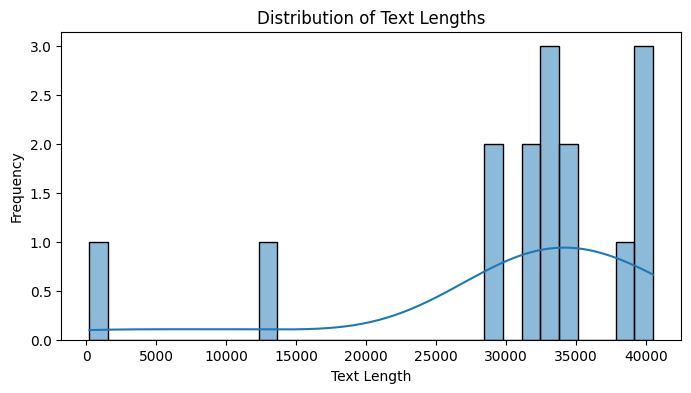

In [ ]:
#  Text length distribution
dfc["text_length"] = dfc["text"].astype(str).apply(len)

plt.figure(figsize=(8,4))
sns.histplot(dfc["text_length"], bins=30, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

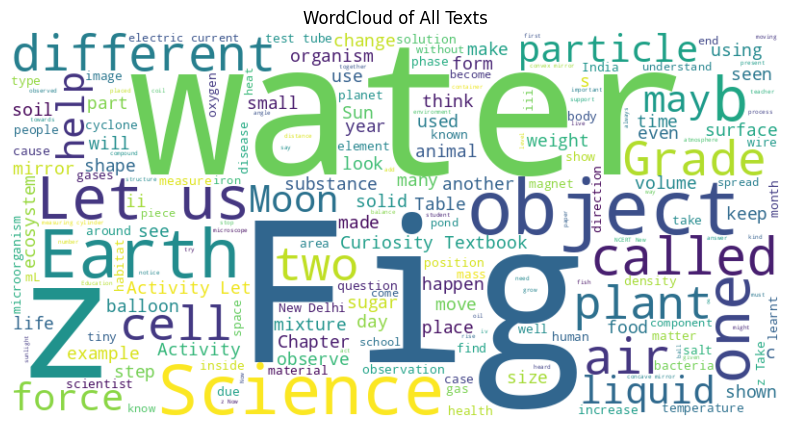

In [ ]:
#  WordCloud for all text
all_text = " ".join(dfc["text"].astype(str).tolist())

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of All Texts")
plt.show()


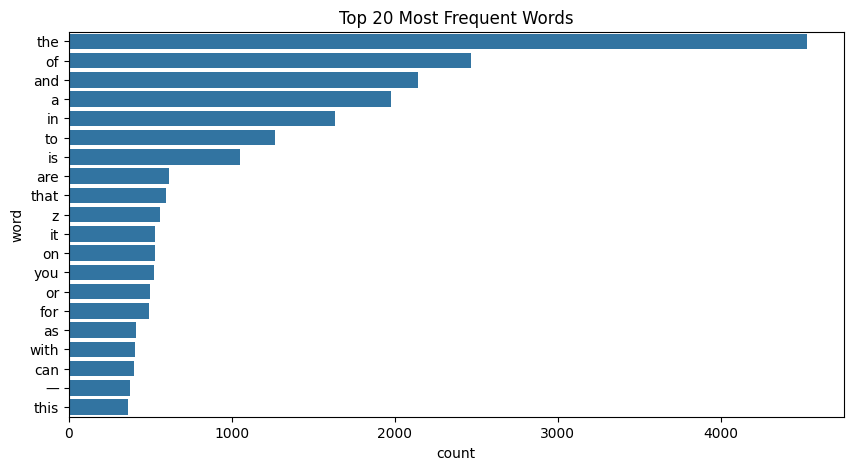

In [ ]:
#  Most common words (basic token split)
words = all_text.lower().split()
word_freq = Counter(words).most_common(20)

freq_df = pd.DataFrame(word_freq, columns=["word","count"])

plt.figure(figsize=(10,5))
sns.barplot(data=freq_df, x="count", y="word")
plt.title("Top 20 Most Frequent Words")
plt.show()


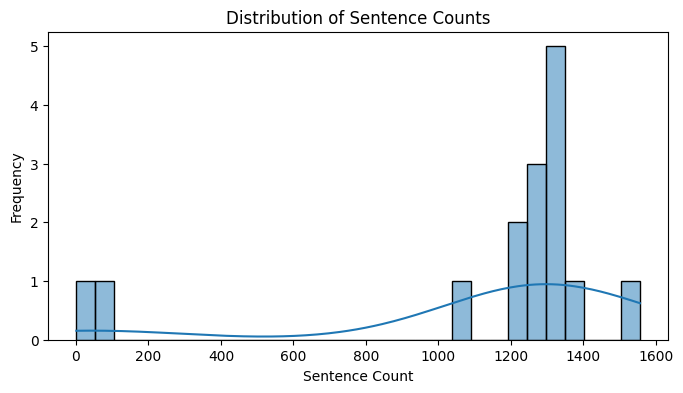

In [ ]:
#  Sentence length distribution (optional)
dfc["sentence_count"] = dfc["text"].astype(str).apply(lambda x: len(x.split(".")))

plt.figure(figsize=(8,4))
sns.histplot(dfc["sentence_count"], bins=30, kde=True)
plt.title("Distribution of Sentence Counts")
plt.xlabel("Sentence Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
class IndexBundle:
    index_path: str
    meta_path: str
    dim: int
    chunks: List[Dict[str,Any]]


In [ ]:
def build_faiss_index(chunks: List[Dict[str,Any]], embed_model="sentence-transformers/all-MiniLM-L6-v2", out_dir="artifacts"):
    os.makedirs(out_dir, exist_ok=True)
    model = SentenceTransformer(embed_model)
    texts = [c["text"] for c in chunks]
    print("Encoding", len(texts), "chunks...")
    embs = model.encode(texts, normalize_embeddings=True, show_progress_bar=True, batch_size=64)
    embs = np.array(embs).astype('float32')
    dim = embs.shape[1]
    # Using IndexFlatIP for normalized dot-product similarity
    index = faiss.IndexFlatIP(dim)
    index.add(embs)
    faiss.write_index(index, os.path.join(out_dir, "faiss.index"))
    # dump chunks metadata
    meta_path = os.path.join(out_dir, "chunks.jsonl")
    with open(meta_path, "w", encoding="utf-8") as f:
        for c in chunks:
            f.write(json.dumps(c, ensure_ascii=False) + "\n")
    print("Saved index and metadata to", out_dir)
    return IndexBundle(index_path=os.path.join(out_dir, "faiss.index"), meta_path=meta_path, dim=dim, chunks=chunks)

Search & Retrieve
def

In [ ]:
def load_bundle(out_dir="artifacts", embed_model="sentence-transformers/all-MiniLM-L6-v2"):
    meta_path = os.path.join(out_dir, "chunks.jsonl")
    chunks = []
    with open(meta_path, "r", encoding="utf-8") as f:
        for line in f:
            chunks.append(json.loads(line))
    idx = faiss.read_index(os.path.join(out_dir, "faiss.index"))
    bundle = IndexBundle(index_path=os.path.join(out_dir, "faiss.index"), meta_path=meta_path, dim=idx.d, chunks=chunks)
    bundle.index = idx
    bundle.embed_model = embed_model
    return bundle


In [ ]:
def search_top_k(query: str, bundle: IndexBundle, k=4):
    model = SentenceTransformer(bundle.embed_model)
    q_emb = model.encode([query], normalize_embeddings=True).astype('float32')
    D, I = bundle.index.search(q_emb, k)
    hits = []
    for score, idx in zip(D[0], I[0]):
        if idx < 0: continue
        c = bundle.chunks[int(idx)]
        hits.append({"score": float(score), **c})
    return hits


RAG generation (LLM or extractive fallback)

In [ ]:
SYLLABUS_GUARDRAIL = "This tutor is focused on Class 8 Science. Please rephrase or ask a syllabus-aligned question."

def generate_answer_with_context(question: str, context_chunks: List[Dict[str,Any]]):
    # Compose context to include short snippets + pages
    context_text = "\n\n".join([f"[p{c['page_start']}] {c['text'][:600]}" for c in context_chunks])
    prompt = f"""
You are a concise Class 8 Science tutor. Answer using ONLY the context below. If the answer is not present, reply exactly: "{SYLLABUS_GUARDRAIL}"
Include inline citations like [pX].

Context:
{context_text}

Question: {question}
Answer:"""

    openai_key = os.getenv("OPENAI_API_KEY","")
    provider = os.getenv("LLM_PROVIDER","openai")

    if provider == "openai" and openai_key:
        # Use official openai package if present
        try:
            import openai
            openai.api_key = openai_key
            resp = openai.ChatCompletion.create(
                model=os.getenv("OPENAI_MODEL","gpt-3.5-turbo"),
                messages=[{"role":"user","content":prompt}],
                temperature=0.2,
                max_tokens=350
            )
            text = resp["choices"][0]["message"]["content"].strip()
            return text
        except Exception as e:
            print("OpenAI call failed:", e)
    # fallback extractive answer: return combined short summary from top chunks
    if not context_chunks:
        return SYLLABUS_GUARDRAIL

    # simple extractive: take first 2 sentences from top chunk(s)
    import nltk
    from nltk.tokenize import sent_tokenize
    sentences = []
    for c in context_chunks[:3]:
        sents = sent_tokenize(c["text"])
        for s in sents[:3]:
            sentences.append(s.strip())
        if len(sentences) >= 6:
            break
    ans = " ".join(sentences)
    # add citations heuristically
    pages = sorted({str(c['page_start']) for c in context_chunks})
    ans = ans + " " + f"[Source: pages {', '.join(pages)}]"
    return ans

End-to-end run function

In [ ]:
def run_rag_question(question: str, bundle: IndexBundle, k=4):
    hits = search_top_k(question, bundle, k=k)
    answer = generate_answer_with_context(question, hits)
    return answer, hits


 Evaluation (10 test queries → BLEU & ROUGE-L)

In [ ]:
# Example test queries (you can edit or replace with your 10 queries)
test_queries = [
    {"id":"Q01", "question":"Define force and list its effects.", "reference_answer":""},
    {"id":"Q02", "question":"Explain the difference between contact and non-contact forces with examples.", "reference_answer":""},
    {"id":"Q03", "question":"What is friction? Mention advantages and disadvantages.", "reference_answer":""},
    {"id":"Q04", "question":"Describe the water cycle stages briefly.", "reference_answer":""},
    {"id":"Q05", "question":"How do plants reproduce asexually? Give two methods.", "reference_answer":""},
    {"id":"Q06", "question":"What are synthetic fibres? Compare with natural fibres.", "reference_answer":""},
    {"id":"Q07", "question":"Explain how sound travels through different media.", "reference_answer":""},
    {"id":"Q08", "question":"Describe the structure and function of the human heart.", "reference_answer":""},
    {"id":"Q09", "question":"What causes air pollution and how can it be controlled?", "reference_answer":""},
    {"id":"Q10", "question":"State the law of conservation of mass with an example.", "reference_answer":""},
]

def evaluate_predictions(predictions_df: pd.DataFrame, out_path="eval/metrics.csv"):
    smoothie = SmoothingFunction().method3
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rows = []
    for _, r in predictions_df.iterrows():
        hyp = (r['answer'] or "").strip()
        ref = (r.get('reference_answer',"") or "").strip()
        bleu = None
        rouge_l = None
        if ref:
            bleu = sentence_bleu([ref.split()], hyp.split(), smoothing_function=smoothie)
            rouge_l = scorer.score(ref, hyp)['rougeL'].fmeasure
        rows.append({**r.to_dict(), "BLEU": bleu, "ROUGE_L": rouge_l})
    out = pd.DataFrame(rows)
    os.makedirs("eval", exist_ok=True)
    out.to_csv(out_path, index=False)
    return out



In [ ]:
# example: run batch inference and save predictions
def batch_run_and_save(bundle, queries=test_queries, out_pred="eval/predictions.csv"):
    rows = []
    for q in queries:
        ans, hits = run_rag_question(q['question'], bundle, k=4)
        rows.append({"id": q["id"], "question": q["question"], "answer": ans, "reference_answer": q.get("reference_answer","")})
    pd.DataFrame(rows).to_csv(out_pred, index=False)
    return pd.DataFrame(rows)


In [ ]:
# Gradio app: load bundle in memory (caution: embeddings model loads too)
def make_gradio_app(bundle):

    def ask(question, top_k):
        if not question or str(question).strip()=="":
            return "Please enter a question.", []
        ans, hits = run_rag_question(question, bundle, k=int(top_k))
        # produce a compact list of hits for UI
        hits_ui = []
        for h in hits:
            hits_ui.append(f"p{h['page_start']} score={h['score']:.3f}\n{h['text'][:400]}...")
        return ans, hits_ui

    with gr.Blocks() as demo:
        gr.Markdown("## Class 8 Science — RAG Tutor (Gradio demo)")
        with gr.Row():
            inp = gr.Textbox(label="Ask a syllabus-aligned question", lines=2, placeholder="E.g., Define force and list its effects.")
            kslider = gr.Slider(minimum=1, maximum=8, step=1, value=4, label="Top-k passages")
            btn = gr.Button("Answer")
        out_ans = gr.Textbox(label="Answer", lines=6)
        out_hits = gr.Dataframe(headers=["Citations & snippets"], max_rows=8)

        btn.click(fn=ask, inputs=[inp, kslider], outputs=[out_ans, out_hits])

    return demo

# Example run:
# bundle = load_bundle("artifacts")
# app = make_gradio_app(bundle)
# app.launch(server_name="0.0.0.0", share=False, server_port=7860)


In [ ]:
# Save cleaned corpus & chunks for reproducibility
def save_corpus_and_chunks(pages, chunks, out_dir="artifacts"):
    os.makedirs(out_dir, exist_ok=True)
    with open(os.path.join(out_dir, "corpus_clean.jsonl"), "w", encoding="utf-8") as f:
        for p in pages:
            f.write(json.dumps(p, ensure_ascii=False) + "\n")
    with open(os.path.join(out_dir, "chunks.jsonl"), "w", encoding="utf-8") as f:
        for c in chunks:
            f.write(json.dumps(c, ensure_ascii=False) + "\n")

# Quick function to build everything from PDF
def build_all_from_pdf(pdf_path, out_dir="artifacts", embed_model="sentence-transformers/all-MiniLM-L6-v2", max_tokens=800):

    pages = extract_pdf_pages(pdf_path)
    pages = clean_pages(pages)
    chunks = chunk_pages(pages)
    save_corpus_and_chunks(pages, chunks, out_dir=out_dir)
    bundle = build_faiss_index(chunks, embed_model=embed_model, out_dir=out_dir)
    return pages, chunks, bundle

# Provide syllabus guardrail example
def syllabus_guardrail_response():
    return SYLLABUS_GUARDRAIL


In [ ]:
class IndexBundle:
    def __init__(self, index_path=None, meta_path=None, dim=None, chunks=None, embed_model=None):
        self.index_path = index_path
        self.meta_path = meta_path
        self.dim = dim
        self.chunks = chunks
        self.embed_model = embed_model # Add embed_model attribute

        # Agar faiss index exist karta hai toh load karo
        import faiss
        if index_path and os.path.exists(index_path):
            self.index = faiss.read_index(index_path)
        else:
            self.index = None

        # Metadata load karo
        if meta_path and os.path.exists(meta_path):
            import json
            with open(meta_path, "r", encoding="utf-8") as f:
                self.metadata = [json.loads(line) for line in f]
        else:
            self.metadata = []

In [ ]:
out_dir = "artifacts"
meta_path = os.path.join(out_dir, "chunks.jsonl")
dim = 384   # MiniLM-L6-v2 embeddings ka dimension
chunks = [] # agar abhi empty test karna ho

bundle = IndexBundle(
    index_path=os.path.join(out_dir, "faiss.index"),
    meta_path=meta_path,
    dim=dim,
    chunks=chunks
)


In [ ]:
# 1) Set path to your PDF
PDF_PATH = "/content/hecu1dd/hecu101.pdf"

# 2) Build pages + chunks
pages, chunks, bundle = build_all_from_pdf(
    PDF_PATH,
    out_dir="artifacts",
    embed_model="sentence-transformers/all-MiniLM-L6-v2"
)

print("Pages:", len(pages))
print("Chunks:", len(chunks))
print("Index dim:", bundle.dim)

# Ensure chunks save ho rahe hain
bundle.chunks = chunks
print("Bundle chunks:", len(bundle.chunks))


Encoding 22 chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Saved index and metadata to artifacts
Pages: 7
Chunks: 22
Index dim: 384
Bundle chunks: 22


In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer

# ✅ Embedder
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed_text(text):
    return embedder.encode([text])[0]

def run_rag_question(question, bundle, k=4):
    # 1) Question embedding
    query_vec = embed_text(question).reshape(1, -1)

    # 2) FAISS search
    D, I = bundle.index.search(query_vec, k)

    # 3) Collect hits
    hits = []
    for score, idx in zip(D[0], I[0]):
        if idx == -1:
            continue
        hit = bundle.chunks[idx].copy()
        hit["score"] = float(score)
        hits.append(hit)

    # 4) Build answer
    context = "\n\n".join([h["text"] for h in hits])
    ans = f"Q: {question}\n\nAnswer (based on retrieved text):\n{context[:800]}..."
    return ans, hits


In [ ]:
q = "Define force and list its effects."
ans, hits = run_rag_question(q, bundle, k=4)

print("Answer:\n", ans)
print("\nTop hits:")
for h in hits:
    print(f"- p{h['page_start']} score={h['score']:.3f}")


Answer:
 Q: Define force and list its effects.

Answer (based on retrieved text):
a major role in improving our lives. For example, we use electric current in many ways to help make our lives easier. We depend on the heating effect of electric current to keep us warm, while the magnetic effect helps motors run and machines function. These phenomena depend on fundamental forces. So after watching electricity do work, we move on to study these forces themselves, starting with those that make objects speed up, slow down, or change direction. Understanding forces helps explain why a ball thrown up in the air falls back to the ground, or why a car stops when the brakes are applied. This also leads us to the idea of pressure -- how the force is distributed over an object. The same concepts of force and pressure also decide how air moves. A small difference in pressure can res...

Top hits:
- p3 score=0.544
- p4 score=0.381
- p6 score=0.277
- p3 score=0.245


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load same model used during indexing
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def embed_text(text):
    """Return vector embedding for a given text"""
    return np.array(embedder.encode(text))


In [ ]:
import zipfile
import os

zip_path = "/content/hecu1dd (2).zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List the extracted files to find the PDF name
extracted_files = os.listdir(extract_path)
print("Extracted files:", extracted_files)

# Update the PDF_PATH in the next cell with the actual PDF file name
# PDF_PATH = "/content/your_extracted_file.pdf"

Extracted files: ['.config', 'hecu1dd', 'hecu1dd (2).zip', 'sample_data']


In [ ]:
!pip install gradio


In [ ]:
pages, chunks, bundle = build_all_from_pdf(
    PDF_PATH,
    out_dir="artifacts",
    embed_model="sentence-transformers/all-MiniLM-L6-v2",
    max_tokens=400   # chhota chunk size
)


Encoding 22 chunks...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Saved index and metadata to artifacts


In [ ]:
from transformers import pipeline

summarizer = pipeline("text2text-generation", model="google/flan-t5-small")

def better_answer(question, hits):
    context = "\n".join([h["text"] for h in hits])
    prompt = f"Answer the question based only on the text:\n\n{context}\n\nQ: {question}\nA:"
    result = summarizer(prompt, max_length=150, do_sample=False)
    return result[0]["generated_text"]


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


In [ ]:
import gradio as gr

# Wrapper function for QA
def qa_fn(question):
    if not question.strip():
        return "⚠️ Please enter a question."
    ans, hits = run_rag_question(question, bundle, k=4)
    return ans

# Gradio Interface
demo = gr.Interface(
    fn=qa_fn,
    inputs=gr.Textbox(label="Ask a Question", placeholder="Type your question here..."),
    outputs="text",
    title="📘 AI Tutor",
    description="Ask any question from your uploaded PDF syllabus."
)

# Run app
demo.launch(share=True)  # share=True se public link milega


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://11b63ea6d01223549b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
